# HW4: Wind Power Potential in Iowa
## By Mia Forsline and Alex Yousefivand 
### EDS 223: Spatial Analysis 
### Due 2021-12-03 

## Table of Contents
[1. Introduction](#introduction)

[2. Import necessary packages](#import)

[3. Query feature data](#query)

[4. Merge subqueries](#merge)

[5. Read in wind data from wind_cells_10000 table](#wind)

[6. Calculate number of turbines](#calculate)

[7. Power production](#power)

[8. Conclusion](#conclusion)

[9. Future research](#future)

<a id='introduction'></a>
# 1. Introduction
We aim to estimate the maximum potential annual wind energy production of the entire state of Iowa. Specifically, we plan to calculate the number of megawatt hours (MWh) that could be generated by 3.45 MW wind turbines placed on all suitable land.

Determining the total number of possible wind turbines and MWh of energy that could be produced is useful to inform cost-benefit analyses of renewable energy production. 

To accomplish this task, we utilized Python and SQL to: 
- identify land in Iowa suitable to install Vestas V136-3.45 MW turbines, assuming: 
    - a 150m hub height (H)
    - rotor diameter of 136m (d)
    - and that turbine towers must be at least 5 rotor diameters away from each other 
- calculate the total number of wind turbines that can fit within the suitable areas 
- calculate the total annual energy production (GWh) using the maximum possible number of new wind turbines 

When calculating the number of wind turbines and the total annual energy production, we evaluated two different siting scenarios: 
1. Residential buildings have to be at least 3H (450m) away from a wind turbine
2. Residential buildings have to be at least 10H (1,500m) away from a wind turbine

Other than residential buildings, both scenarios involved the same minimum distance from a wind turbine for all other feature classes: 
- non-residential buildings: 450m (3H)
- airports: 7500m 
- military facilities, nature reserves, parks, wetlands, lakes: 0m 
- highways and railroads: 300m (2H)
- rivers: 150m (H)
- power lines: 300m (2H) 
- power plants: 150m (H)
- existing wind turbines: 650m (5d)

Data was sourced from [OpenStreetMap](https://www.openstreetmap.org/#map=4/38.01/-95.84), and metadata for each feature can be found [here](https://wiki.openstreetmap.org/wiki/Map_features). 

<a id='import'></a>
# 2. Import necessary packages 

In [18]:
import sqlalchemy
import psycopg2
import geopandas as gpd
import math 

<a id='query'></a>
# 3. Query feature data
## Use `sqlalchemy` and `psycopg2` to connect to PostGIS database (`osmiowa`)
- set up database universal reference identifier 
- modify the template to connect to the `osmiowa` database
- establish the database connection 

In [19]:
pg_uri_template = 'postgresql+psycopg2://{user}:{pwd}@{host}/{db_name}'

db_uri = pg_uri_template.format(
    host='128.111.89.111',
    user='eds223_students',
    pwd='eds223',
    db_name='osmiowa'
)
db = sqlalchemy.create_engine(db_uri)

## Siting Constraints
- Note: all data is in EPSG 26975, aka NAD 83 / Iowa North
    - units are meters
- create variables to store siting paramater values 

In [20]:
H = 150
H2 = 300
H3 = 450
H10 = 1500
airport_buffer = 7500
d5 = 680
d = 136

### Buildings
- residential buildings (scenario 1: 3H = 450m) 
- residential buildings (scenario 2: 10H = 1,500m) 
- non-residential buildings: 3H = 450m 

In [21]:
sql_res_buildings_1 = f"""SELECT osm_id, building, landuse, aeroway, military, highway, railway,
leisure, planet_osm_polygon.natural, planet_osm_polygon.power, "generator:source", water, waterway,
ST_BUFFER(way, {H3}) as way 
FROM planet_osm_polygon 
WHERE building in ('yes', 'residential', 'apartments', 'house', 'static_caravan', 'detached')
OR landuse = 'residential'
OR place = 'town'"""

In [22]:
sql_res_buildings_2 = f"""SELECT osm_id, building, landuse, aeroway, military, highway, railway,
leisure, planet_osm_polygon.natural, planet_osm_polygon.power, "generator:source", water, waterway, ST_BUFFER(way, {H10}) as way
FROM planet_osm_polygon
WHERE building in ('yes', 'residential', 'apartments', 'house', 'static_caravan', 'detached')
OR landuse = 'residential'
OR place = 'town'
"""

In [23]:
sql_non_res_buildings = f"""SELECT osm_id, building, landuse, aeroway, military, highway, railway,
leisure, planet_osm_polygon.natural, planet_osm_polygon.power, "generator:source", water, waterway, ST_BUFFER(way, {H3}) as way
FROM planet_osm_polygon 
WHERE building NOT in ('yes', 'residential', 'apartments', 'house', 'static_caravan', 'detached')
OR landuse = 'residential'
OR place = 'town'
"""

### Airports 
- aeroway: 7500m

In [24]:
sql_airports = f"""SELECT osm_id, building, landuse, aeroway, military, highway, railway,
leisure, planet_osm_polygon.natural, planet_osm_polygon.power, "generator:source", water, waterway, ST_BUFFER(way, {airport_buffer}) as way
FROM planet_osm_polygon
WHERE aeroway IN ('apron', 'navigationaid', NULL, 'taxiway', 'runway', 'helipad', 'terminal', 'hangar', 'aerodrome')"""

### Military Facilities 
- military: 0m 

In [25]:
sql_gov_military = """SELECT osm_id, building, landuse, aeroway, military, highway, railway,
leisure, planet_osm_polygon.natural, planet_osm_polygon.power, "generator:source", water, waterway, way
FROM planet_osm_polygon 
WHERE military IS NOT NULL 
OR landuse in ('military')"""

### Highways and railroads 
- railways that are not abandoned or unused: 2H = 300m
- highway: 2H = 300m
    - motorways, trunks, primary roads, secondary roads, and their respective links

In [26]:
sql_rail = f"""SELECT osm_id, building, landuse, aeroway, military, highway, railway,
leisure, planet_osm_line.natural, planet_osm_line.power, "generator:source", water, waterway, ST_BUFFER(way, {H2}) as way
FROM planet_osm_line
WHERE railway not in ('abandoned', 'disused')"""

In [27]:
sql_highway = f"""SELECT osm_id, building, landuse, aeroway, military, highway, railway,
leisure, planet_osm_line.natural, planet_osm_line.power, "generator:source", water, waterway, ST_BUFFER(way, {H2}) as way
FROM planet_osm_line
WHERE highway in ('motorway', 'motorway_link', 'trunk', 'trunk_link', 'primary', 'primary_link', 'secondary', 'secondary_link')
"""

### Nature reserves, parks, and wetlands
- leisure and natural: 0m 

In [28]:
sql_wetland = """SELECT osm_id, building, landuse, aeroway, military, highway, railway,
leisure, planet_osm_polygon.natural, planet_osm_polygon.power, "generator:source", water, waterway, way
FROM planet_osm_polygon
WHERE leisure in ('nature_reserve', 'park')
OR planet_osm_polygon.natural = 'wetland'"""

### Rivers
- waterway: 1H = 150m 

In [29]:
sql_river = f"""SELECT osm_id, building, landuse, aeroway, military, highway, railway,
leisure, planet_osm_line.natural, planet_osm_line.power, "generator:source", water, waterway, ST_BUFFER(way, {H}) as way
FROM planet_osm_line
WHERE waterway in ('river')"""

### Lakes
- water: 0m 

In [30]:
sql_lake = """SELECT osm_id, building, landuse, aeroway, military, highway, railway,
leisure, planet_osm_polygon.natural, planet_osm_polygon.power, "generator:source", water, waterway, way
FROM planet_osm_polygon
WHERE water in ('lake', 'reservoir', 'pond')"""

### Power Lines 
- power: 2H = 300m

In [31]:
sql_pline = f"""SELECT osm_id, building, landuse, aeroway, military, highway, railway,
leisure, planet_osm_line.natural, planet_osm_line.power, "generator:source", water, waterway, ST_BUFFER(way, {H2}) as way
FROM planet_osm_line
WHERE planet_osm_line.power IS NOT NULL"""

### Power plants
- power: 1H = 150m

In [32]:
sql_pplant = f"""SELECT osm_id, building, landuse, aeroway, military, highway, railway,
leisure, planet_osm_polygon.natural, planet_osm_polygon.power, "generator:source", water, waterway, ST_BUFFER(way, {H}) as way
FROM planet_osm_polygon
WHERE planet_osm_polygon.power IS NOT NULL"""

### Existing Wind Turbines 
- Turbine towers must be at least 5 rotor diameters apart
    - d = 136m
    - 5d = 680m 

In [33]:
sql_wind = f"""SELECT osm_id, building, landuse, aeroway, military, highway, railway,
leisure, planet_osm_point.natural, planet_osm_point.power, "generator:source", water, waterway, ST_BUFFER(way, {d5}) as way
FROM planet_osm_point
WHERE "generator:source" in ('wind')"""

<a id='merge'></a>
# 4. Merge subqueries
## Scenario 1

In [34]:
sql_merge = f"""
{sql_res_buildings_1}
UNION
{sql_non_res_buildings}
UNION 
{sql_airports}
UNION
{sql_gov_military}
UNION
{sql_rail}
UNION
{sql_highway}
UNION
{sql_wetland}
UNION
{sql_river}
UNION
{sql_lake}
UNION
{sql_pline}
UNION
{sql_pplant}
UNION
{sql_wind}
"""
siting_constraints_1 = gpd.read_postgis(sql_merge, con = db, geom_col = 'way')

## Scenario 2

In [35]:
sql_merge = f"""
{sql_res_buildings_2}
UNION
{sql_non_res_buildings}
UNION 
{sql_airports}
UNION
{sql_gov_military}
UNION
{sql_rail}
UNION
{sql_highway}
UNION
{sql_wetland}
UNION
{sql_river}
UNION
{sql_lake}
UNION
{sql_pline}
UNION
{sql_pplant}
UNION
{sql_wind}
"""
siting_constraints_2 = gpd.read_postgis(sql_merge, con = db, geom_col = 'way')

<a id='wind'></a>
# 5. Read in wind data from `wind_cells_10000` table
- identify `suitable_cells` using `overlay()`
- visualize suitable areas in Iowa for both scenarios 

In [36]:
sql_wcells = """SELECT wind_cells_10000.id, geom as way, wind_speed 
FROM wind_cells_10000"""

wind_cells = gpd.read_postgis(sql_wcells, con = db, geom_col = 'way')

In [37]:
suitable_cells_1 = wind_cells.overlay(siting_constraints_1, how='difference')
suitable_cells_2 = wind_cells.overlay(siting_constraints_2, how='difference')

C:\Users\Alex Vand\.conda\envs\eds223\lib\site-packages\geopandas\geodataframe.py:2196: UserWarning: `keep_geom_type=True` in overlay resulted in 88 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


## Scenario 1

<AxesSubplot:>

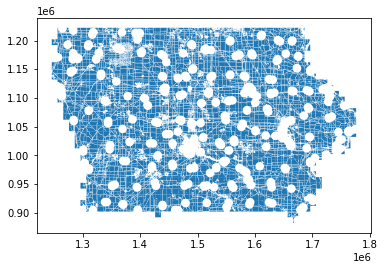

In [38]:
suitable_cells_1.plot()

## Scenario 2

<AxesSubplot:>

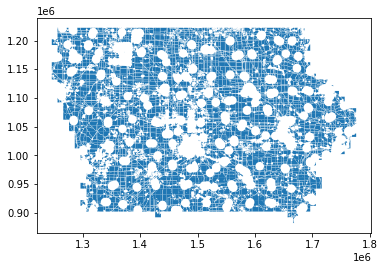

In [39]:
suitable_cells_2.plot()

<a id='calculate'></a>
# 6. Calculate number of turbines
- calculate and define the `turbine_footprint`, aka the area (m$^2$) of the circular buffer between wind turbines 
    - `turbine_footprint`: $\text{Area} = \pi  r^2$, where $r = 5\text{d} = 680\text{m}$

In [40]:
turbine_footprint = math.pi * (d5) ** 2

## Scenario 1
- calculate area in m$^2$ of each suitable cell 
- calculate the fractional number of turbines that can fit in each cell
- sum to find the total number of turbines that can fit in the state of Iowa 

In [41]:
suitable_cells_1['area_m2'] = suitable_cells_1['way'].area
suitable_cells_1['num_turbine'] = suitable_cells_1['area_m2'] / turbine_footprint
tot_turbines_1 = suitable_cells_1['num_turbine'].sum()

## Scenario 2
- calculate area in m$^2$ of each suitable cell 
- calculate the fractional number of turbines that can fit in each cell
- sum to find the total number of turbines that can fit in the state of Iowa 
    - note: Scenario 2 should be able to fit fewer turbines than Scenario 1 because the residential building buffers are larger 

In [42]:
suitable_cells_2['area_m2'] = suitable_cells_2['way'].area
suitable_cells_2['num_turbine'] = suitable_cells_2['area_m2'] / turbine_footprint
tot_turbines_2 = suitable_cells_2['num_turbine'].sum()

<a id='power'></a>
# 7. Power production
- Calculate the maximum annual wind energy production in Iowa (GWh) using the energy formula $E = 2.6 \text{s m}^{-1} v + -5 \text{GWh}$, where
    - $E = $ energy production per turbine in GWh
    - $v = $ average annual wind speed in ms$^{-1}$

## Scenario 1

In [43]:
suitable_cells_1['energy_GWh'] = (2.6 * suitable_cells_1['wind_speed'] - 5) * suitable_cells_1['num_turbine']
energy1 = suitable_cells_1['energy_GWh'].sum()

## Scenario 2
- Note: Scenario 2 should have slightly lower potential maximum annual wind energy potential than Scenario 1

In [44]:
suitable_cells_2['energy_GWh'] = (2.6 * suitable_cells_2['wind_speed'] - 5) * suitable_cells_2['num_turbine']
energy2 = suitable_cells_2['energy_GWh'].sum()

<a id='conclusion'></a>
# 8. Conclusion

In this assignment we examined PostGIS OSM data to determine all of the land in Iowa that would be suitable for wind turbines given particular siting constraints under two different residential buffer scenarios. After computing the suitable area, we then calculated the total number of turbines that could be placed in this area along with the total annual energy production that would be realized by the maximum possible number of new turbines.

In [45]:
print("We calculated a turbine footprint of approximately {} square meters.".format(round(turbine_footprint, 2)))
print("For scenario 1, we estimate the total number of turbines that fit in the suitable area of Iowa to be about {}.".format(round(tot_turbines_1)))
print("Therefore for scenario 1, the maximum annual wind energy production in Iowa is {} GWh.".format(round(energy1)))
print("For scenario 2, we estimate the total number of turbines that fit in the suitable area of Iowa to be about {}.".format(round(tot_turbines_2)))
print("Therefore for scenario 2, the maximum annual wind energy production in Iowa is {} GWh.".format(round(energy2)))

We calculated a turbine footprint of approximately 1452672.44 square meters.
For scenario 1, we estimate the total number of turbines that fit in the suitable area of Iowa to be about 57285.
Therefore for scenario 1, the maximum annual wind energy production in Iowa is 1064145 GWh.
For scenario 2, we estimate the total number of turbines that fit in the suitable area of Iowa to be about 52055.
Therefore for scenario 2, the maximum annual wind energy production in Iowa is 966999 GWh.


<a id='future'></a>
# 9. Future research

Our findings can help inform future renewable energy plans in Iowa, as well as other states and even countries.